In [1]:
import torch
from torchvision import datasets
import syft as sy

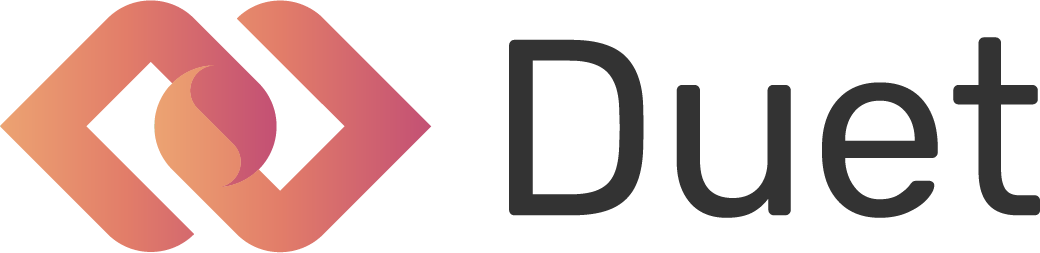

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet1 = sy.join_duet(loopback=True)

In [3]:
duet1.store.pandas

ID           Tags  \
0  <UID: 21f6c5f36a884e0793cb74f6521526dd>      [flatten]   
1  <UID: 750be96e84884b67a6d14f2dafbf5729>  [flatten_val]   

                 Description             object_type  
0                  flattened  <class 'torch.Tensor'>  
1  flattened validation data  <class 'torch.Tensor'>

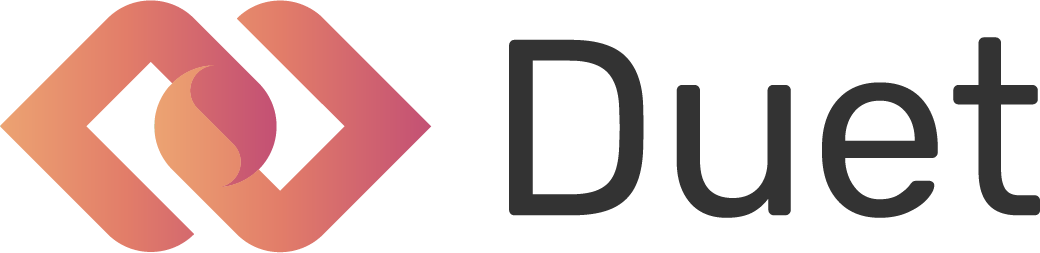

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [4]:
duet2 = sy.join_duet(loopback=True)

In [5]:
duet2.store.pandas

ID           Tags  \
0  <UID: a06779fd44bd4b07b1e9b75c94a71eab>      [flatten]   
1  <UID: 18f76cedfeb34db3971c1d520885b7ee>  [flatten_val]   

                 Description             object_type  
0                  flattened  <class 'torch.Tensor'>  
1  flattened validation data  <class 'torch.Tensor'>

In [6]:
labels = datasets.MNIST("mnist", download=True, train=True).targets[:10_000]  # don't need all to demonstrate value
labels_val = datasets.MNIST("mnist", download=True, train=False).targets[:5_000]

print(labels.shape, labels_val.shape)

torch.Size([10000]) torch.Size([5000])


In [7]:
train1 = duet1.store["flatten"]
val1 = duet1.store["flatten_val"]

train2 = duet2.store["flatten"]
val2 = duet2.store["flatten_val"]

In [8]:
dl_1 = duet1.torch.utils.data.DataLoader(train1, batch_size=128)
dl_1val = duet1.torch.utils.data.DataLoader(val1, batch_size=128)

dl_2 = duet2.torch.utils.data.DataLoader(train2, batch_size=128)
dl_2val = duet2.torch.utils.data.DataLoader(val2, batch_size=128)

dl_local = torch.utils.data.DataLoader(labels, batch_size=128)
dl_localval = torch.utils.data.DataLoader(labels_val, batch_size=128)

In [9]:
# In order to serialise our model we need to define it as below
from torch import nn

hidden_sizes = [128, 500]
output_size = 10

class SyNet_client(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet_client, self).__init__(torch_ref=torch_ref)
        self.lin = self.torch_ref.nn.Linear(392,64)
        
    def forward(self, x):
        x = self.lin(x)
        x = self.torch_ref.nn.functional.relu(x)
        return x
    
class SyNet_server(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet_server, self).__init__(torch_ref=torch_ref)
        self.lin2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lin3 = nn.Linear(hidden_sizes[1], output_size)
        self.sft = nn.LogSoftmax(dim=1) 
        
    def forward(self, x):
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.lin3(x)
        x = self.sft(x)
        return x

In [10]:
#Model 1
model1 = SyNet_client(torch)
model1_ptr = model1.send(duet1)
opt1 = duet1.torch.optim.SGD(params=model1_ptr.parameters(),lr=0.01)

#Model 2
model2 = SyNet_client(torch)
model2_ptr = model2.send(duet2)
opt2 = duet2.torch.optim.SGD(params=model2_ptr.parameters(),lr=0.01)

#Model 3
model3 = SyNet_server(torch)
local_opt = torch.optim.SGD(params=model3.parameters(),lr=0.1)

In [ ]:
for epoch in range(4):
    train_correct = 0
    train_total = 0
    
    for in1, in2, label in zip(dl_1, dl_2, dl_local):
        opt1.zero_grad()
        opt2.zero_grad()
        local_opt.zero_grad()

        a1_ptr = model1_ptr(in1)
        a1 = a1_ptr.clone().get(request_block=True)

        a2_ptr = model2_ptr(in2)
        a2 = a2_ptr.clone().get(request_block=True)
        
        a = torch.cat((a1, a2), 1)
        y = model3(a)
        
        criterion = nn.NLLLoss()
        loss = criterion(y, label.long())
        
        train_correct += y.max(1)[1].eq(label).sum().item()
        train_total += y.shape[0]
        print(loss)
        
        loss.backward()

        g1_ptr = a1.grad.clone().send(duet1)
        g2_ptr = a2.grad.clone().send(duet2)
        
        a1_ptr.backward(g1_ptr)
        a2_ptr.backward(g2_ptr)
        
        local_opt.step()
        opt1.step()
        opt2.step()
        
    correct = 0
    total = 0
    for in_val1, in_val2, label_val in zip(dl_1val, dl_2val, dl_localval):
        a1_ptr = model1_ptr(in_val1)
        a1 = a1_ptr.clone().get(request_block=True)

        a2_ptr = model2_ptr(in_val2)
        a2 = a2_ptr.clone().get(request_block=True)

        a = torch.cat((a1, a2), 1)
        y = model3(a)

        correct += y.max(1)[1].eq(label_val).sum().item()
        total += y.shape[0]
    print(f"Train Accuracy: {100*train_correct/train_total:.3f}%")
    print(f"Val Accuracy: {100*correct/total:.3f}%")
        

tensor(2.3031, grad_fn=<NllLossBackward>)
tensor(2.2880, grad_fn=<NllLossBackward>)
tensor(2.2742, grad_fn=<NllLossBackward>)
tensor(2.2672, grad_fn=<NllLossBackward>)
tensor(2.2819, grad_fn=<NllLossBackward>)
tensor(2.2679, grad_fn=<NllLossBackward>)
tensor(2.2593, grad_fn=<NllLossBackward>)
tensor(2.2418, grad_fn=<NllLossBackward>)


Exception in callback Transaction.__retry()
handle: <TimerHandle when=494.949255593 Transaction.__retry()>
Traceback (most recent call last):
  File "/Users/adamhall/anaconda3/envs/pysyft/lib/python3.8/site-packages/nest_asyncio.py", line 199, in run
    ctx.run(self._callback, *self._args)
  File "/Users/adamhall/anaconda3/envs/pysyft/lib/python3.8/site-packages/aioice/stun.py", line 299, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "/Users/adamhall/anaconda3/envs/pysyft/lib/python3.8/asyncio/futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\xf1\x94\xba'), ('fdaa:bbcc:dd...1e2:c69c:939b', 57607))>


tensor(2.2421, grad_fn=<NllLossBackward>)
tensor(2.2219, grad_fn=<NllLossBackward>)
tensor(2.2395, grad_fn=<NllLossBackward>)
tensor(2.2204, grad_fn=<NllLossBackward>)
tensor(2.2187, grad_fn=<NllLossBackward>)
tensor(2.1843, grad_fn=<NllLossBackward>)
tensor(2.1873, grad_fn=<NllLossBackward>)
tensor(2.1792, grad_fn=<NllLossBackward>)
tensor(2.1575, grad_fn=<NllLossBackward>)
tensor(2.1533, grad_fn=<NllLossBackward>)
tensor(2.1675, grad_fn=<NllLossBackward>)
tensor(2.1448, grad_fn=<NllLossBackward>)
tensor(2.1233, grad_fn=<NllLossBackward>)
tensor(2.1342, grad_fn=<NllLossBackward>)
tensor(2.0661, grad_fn=<NllLossBackward>)
tensor(2.1341, grad_fn=<NllLossBackward>)
tensor(2.1050, grad_fn=<NllLossBackward>)
tensor(2.0911, grad_fn=<NllLossBackward>)
tensor(2.0552, grad_fn=<NllLossBackward>)
tensor(2.0687, grad_fn=<NllLossBackward>)
tensor(2.0337, grad_fn=<NllLossBackward>)
tensor(2.0275, grad_fn=<NllLossBackward>)
tensor(2.0008, grad_fn=<NllLossBackward>)
tensor(1.9973, grad_fn=<NllLossBac

tensor(0.4994, grad_fn=<NllLossBackward>)
tensor(0.4240, grad_fn=<NllLossBackward>)
tensor(0.5047, grad_fn=<NllLossBackward>)
tensor(0.3915, grad_fn=<NllLossBackward>)
tensor(0.3380, grad_fn=<NllLossBackward>)
tensor(0.4176, grad_fn=<NllLossBackward>)
tensor(0.3207, grad_fn=<NllLossBackward>)
tensor(0.4468, grad_fn=<NllLossBackward>)
tensor(0.3182, grad_fn=<NllLossBackward>)
tensor(0.3767, grad_fn=<NllLossBackward>)
tensor(0.5967, grad_fn=<NllLossBackward>)
